In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import json

C:\Users\yanni\AppData\Local\Temp\ipykernel_11800\390751635.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
# Charger le fichier CSV
file_path = './Datas/olympic_results.csv'
data = pd.read_csv(file_path)

In [3]:
# Sélectionner les colonnes pertinentes
# On garde seulement les colonnes liées au pays, type de médaille, jeu olympique, et URL de l'athlète
medals_data = data[['country_name', 'medal_type', 'slug_game', 'athlete_url']].dropna(subset=['medal_type'])

# Extraire l'année des jeux olympiques de la colonne 'slug_game'
medals_data['year'] = medals_data['slug_game'].str.extract(r'(\d{4})').astype(int)

# Dictionnaire de correction pour uniformiser les noms de pays
country_dict = {
    'German Democratic Republic (Germany)':'Germany', 
    'Federal Republic of Germany':'Germany',
    "Democratic People's Republic of Korea":'North Korea',
    "ROC":"China",
    "Republic of Korea":"South Korea",
    "People's Republic of China":'China',
    "Islamic Republic of Iran":'Iran',
    "United States of America":'USA'}


In [4]:

# Remplacer les noms de pays par ceux du dictionnaire
medals_data['country_name'] = medals_data['country_name'].replace(country_dict)

# Ajouter une colonne pour le nombre d'athlètes par pays par année
medals_data['num_athletes'] = medals_data.groupby(['country_name', 'year'])['athlete_url'].transform('nunique')

# Encoder les médailles en valeurs numériques
medals_data['medal_value'] = medals_data['medal_type'].map({'GOLD': 3, 'SILVER': 2, 'BRONZE': 1})

# Agréger les données par pays et par année
medals_by_country_year = medals_data.groupby(['country_name', 'year', 'num_athletes'])['medal_value'].sum().reset_index()

# Renommer les colonnes pour plus de clarté
medals_by_country_year.columns = ['country_name', 'year', 'num_athletes', 'total_medal_value']


# Encoder les noms de pays en valeurs numériques
label_encoder = LabelEncoder()
medals_by_country_year['country_encoded'] = label_encoder.fit_transform(medals_by_country_year['country_name'])


In [5]:

# Séparer les données d'entraînement (jusqu'à 2016) et de test (2020)
train_data = medals_by_country_year[medals_by_country_year['year'] <= 2016]
test_data = medals_by_country_year[medals_by_country_year['year'] == 2020]

# Séparer les caractéristiques (X) et la cible (y)
X_train = train_data[['country_encoded', 'year', 'num_athletes']]
y_train = train_data['total_medal_value']
X_test = test_data[['country_encoded', 'year', 'num_athletes']]
y_test = test_data['total_medal_value']

In [6]:
# Définir une fonction de construction du modèle pour Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        activation='relu', input_dim=3))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialiser Keras Tuner pour la recherche des meilleurs hyperparamètres
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='olympic_medals'
)

# Rechercher les meilleurs hyperparamètres
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Récupérer le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]


Reloading Tuner from my_dir\olympic_medals\tuner0.json



c:\Users\yanni\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\yanni\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
# Entraîner le meilleur modèle
best_model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2)


Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 136.4371 - val_loss: 427.3803
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 204.3654 - val_loss: 320.6375
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151.5058 - val_loss: 344.8885
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 91.2598 - val_loss: 574.7960
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101.5158 - val_loss: 532.8854
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117.3366 - val_loss: 434.7303
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 88.0882 - val_loss: 611.4276
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 135.3431 - val_loss: 395.1767
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97.7188 - val_loss: 366.3841
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135.5697 - val_loss: 292.8049
Epoch 11/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91.2515 - val_loss: 272.61

In [8]:
# Évaluer le modèle
loss = best_model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Faire des prédictions
predictions = best_model.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.2026 
Test loss: 39.943790435791016
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [10]:
import numpy as np
import matplotlib.pyplot as plt
# Convertir les prédictions et les valeurs réelles en DataFrame
comparison = pd.DataFrame({
    'Country': label_encoder.inverse_transform(X_test['country_encoded']),
    'Actual': y_test,
    'Predicted': np.squeeze(predictions)
})

# Trier les prédictions par le nombre de médailles actuelles
sorted_predictions = comparison.sort_values(by='Actual', ascending=False)

# Afficher les prédictions triées
print(sorted_predictions.head(10))



            Country  Actual   Predicted
286           China     334  352.687836
1482            USA     232  239.509232
606   Great Britain     130  132.900894
823           Japan     124  131.702438
70        Australia      86   58.433750
774           Italy      70   72.277008
986     Netherlands      68   54.582790
564         Germany      68   53.846485
522          France      65   43.376934
261          Canada      44   34.832169


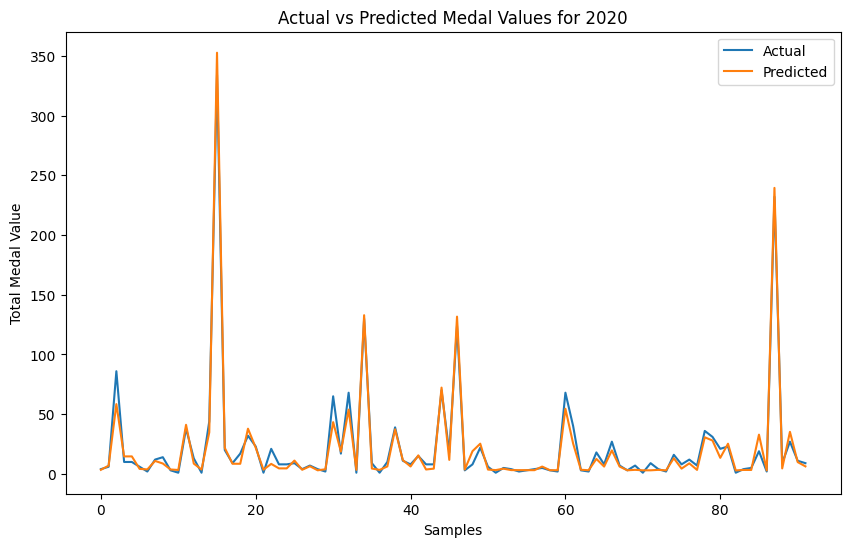

In [11]:
# Visualisation des valeurs réelles et prédites
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Total Medal Value')
plt.title('Actual vs Predicted Medal Values for 2020')
plt.show()


In [12]:

# Convertir le DataFrame en dictionnaire
sorted_predictions_dict = sorted_predictions.to_dict(orient='records')

# Sauvegarder le dictionnaire en fichier JSON
with open('predictions.json', 'w') as f:
    json.dump(sorted_predictions_dict, f)
